##### Import necessary libraries

In [142]:
import importlib
import scraper
import matplotlib.pyplot as plt
import pandas as pd
import re

importlib.reload(scraper)  # Forces reloading of the scraper module

# from scraper import fetch_sold_listings, get_listing_details, debug_pagination, clean_price, categorize_bedrooms, save_table_as_image, save_listing_url_html

<module 'scraper' from 'c:\\Users\\USER\\Documents\\HouseSigma Scraper\\housesigma-scraper\\scraper.py'>

##### Test get listing details function

In [120]:
prices_df_temp = scraper.get_listing_details("housesigma_page_1.html")

print("\nPrices DF columns: ", prices_df_temp.columns)

print("\nFirst Address:", prices_df_temp['Address'][0])
print("\nFirst url:", prices_df_temp['Listing URL'][0])

print("\n" + "=" * 50)  # Separator line
print(prices_df_temp.shape)
print("\n" + "=" * 50)
print(prices_df_temp)

Reading html file

Prices DF columns:  Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code', 'Listing URL'], dtype='object')

First Address: 623 - 88 Colgate Ave , Toronto - South Riverdale

First url: https://housesigma.com/on/toronto-real-estate/623-88-colgate-ave/home/DnM697koZNd7bmwe/

(20, 8)

   Asking Price  Sold Price                          Address                              Unit Type     Bedrooms Bathrooms Postal Code  \
0     $998,000     $975,000           623 - 88 Colgate Ave , Toronto - South Riverdale        Condo Apt      2        2       M4M0A6     
1   $1,259,000   $1,349,000   84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside         Detached      4        5       M1N2J6     
2   $3,599,900   $3,250,000                    501 Avonwood Dr , Mississauga - Mineola         Detached      4        4       L5G1Y8     
3     $825,000     $780,000        314 - 199 Pine Grove Rd , Vaughan - East Woodbridge  Condo Townhou

##### Run the HouseSigma scraper

In [121]:
# Run the scraper
url = "https://housesigma.com/on/sold/map/?status=sold&lat=43.715564&lon=-79.418602&zoom=10&page=1&view=list"

# debug_pagination(url)

# sold_data_df = scraper.fetch_sold_listings(url, 40)

##### Check scraped df

In [122]:
print("\nDataframe shape: ", sold_data_df.shape)
print("\n" + "=" * 50)  # Separator line
print(sold_data_df.columns)
print("\n" + "=" * 50)
print(sold_data_df.head(20))


Dataframe shape:  (800, 8)

Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code', 'Listing URL'], dtype='object')

    Asking Price   Sold Price                           Address                              Unit Type     Bedrooms Bathrooms Postal Code  \
0    $998,000.00   $975,000.00           623 - 88 Colgate Ave , Toronto - South Riverdale        Condo Apt      2        2       M4M0A6     
1  $1,259,000.00 $1,349,000.00   84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside         Detached      4        5       M1N2J6     
2  $3,599,900.00 $3,250,000.00                    501 Avonwood Dr , Mississauga - Mineola         Detached      4        4       L5G1Y8     
3    $825,000.00   $780,000.00        314 - 199 Pine Grove Rd , Vaughan - East Woodbridge  Condo Townhouse      2        2       L4L0H8     
4    $559,000.00   $529,000.00  517 - 168 Simcoe St , Toronto - Waterfront Communities C1        Condo Apt      1        1       M5H

##### Apply Unit Type mapping

In [123]:
print(sold_data_df.columns)

# Print the initial number of rows
initial_row_count = sold_data_df.shape[0]
print(f"Initial number of rows: {initial_row_count}")

# Remove duplicates
sold_data_df_nodup = sold_data_df.drop_duplicates().copy().reset_index(drop=True)

# Print the number of rows after removing duplicates
final_row_count = sold_data_df_nodup.shape[0]
print(f"Number of rows after removing duplicates: {final_row_count}")

Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code', 'Listing URL'], dtype='object')
Initial number of rows: 800
Number of rows after removing duplicates: 768


In [124]:
# Apply the cleaning function to both columns
price_columns = ["Asking Price", "Sold Price"]
sold_data_df_nodup[price_columns] = sold_data_df_nodup[price_columns].applymap(scraper.clean_price)

category_mapping = {
    "Detached": "Detached",
    "Link": "Detached",
    "Single Family Residence": "Detached",
    "Apartment Unit, Condo/Apt Unit": "Condo Apt",
    "Row/Townhouse": "Freehold Townhouse"
}

sold_data_df_nodup["Unit Type"] = sold_data_df_nodup["Unit Type"].replace(category_mapping)

# List of Unit Types to exclude
exclude_unit_types = ["Other", "Vacant Land", "Parking Space"]

# Filter the DataFrame to exclude these Unit Types
filtered_sold_data_df = sold_data_df_nodup[~sold_data_df_nodup["Unit Type"].isin(exclude_unit_types)].reset_index(drop=True)

filtered_sold_data_df["Bedroom Category"] = filtered_sold_data_df["Bedrooms"].apply(scraper.categorize_bedrooms)

print(len(filtered_sold_data_df.index))
print(filtered_sold_data_df.head(20))

764
    Asking Price   Sold Price                           Address                              Unit Type     Bedrooms Bathrooms Postal Code  \
0    $998,000.00   $975,000.00           623 - 88 Colgate Ave , Toronto - South Riverdale        Condo Apt      2        2       M4M0A6     
1  $1,259,000.00 $1,349,000.00   84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside         Detached      4        5       M1N2J6     
2  $3,599,900.00 $3,250,000.00                    501 Avonwood Dr , Mississauga - Mineola         Detached      4        4       L5G1Y8     
3    $825,000.00   $780,000.00        314 - 199 Pine Grove Rd , Vaughan - East Woodbridge  Condo Townhouse      2        2       L4L0H8     
4    $559,000.00   $529,000.00  517 - 168 Simcoe St , Toronto - Waterfront Communities C1        Condo Apt      1        1       M5H4C9     
5  $1,399,999.00 $1,430,000.00                  22 Sgotto Blvd , Vaughan - Sonoma Heights         Detached      3        4       L4H1X1     
6  $1,295

C:\Users\USER\AppData\Local\Temp\ipykernel_8912\1183079950.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sold_data_df_nodup[price_columns] = sold_data_df_nodup[price_columns].applymap(scraper.clean_price)


##### Calculate average and median prices by Unit Type and by Unit Type and Bedrooms Category

In [125]:
print(filtered_sold_data_df.columns)
print("\n" + "=" * 50)  # Separator line
print(filtered_sold_data_df.shape)

# Average asking and sold prices by unit type
avg_prices = (
    filtered_sold_data_df.groupby("Unit Type")
    .agg(
        Asking_Price_Avg=("Asking Price", "mean"),
        Sold_Price_Avg=("Sold Price", "mean"),
        Sold_Price_Median=("Sold Price", "median"),
        Count=("Asking Price", "count")  # Counting the number of observations
    )
    .reset_index()
)

avg_prices = avg_prices.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Format the average prices and counts for better readability
avg_prices["Asking_Price_Avg"] = avg_prices["Asking_Price_Avg"].apply(lambda x: f"${x:,.0f}")
avg_prices["Sold_Price_Avg"] = avg_prices["Sold_Price_Avg"].apply(lambda x: f"${x:,.0f}")
avg_prices["Sold_Price_Median"] = avg_prices["Sold_Price_Median"].apply(lambda x: f"${x:,.0f}")
avg_prices["Count"] = avg_prices["Count"].apply(lambda x: f"{x:,}")

# Display the formatted table
print("\nAverage Asking and Sold Price by Unit Type:\n")
print(avg_prices.to_string(index=False))

# Group by Unit Type and Bedrooms, then calculate average Asking and Sold Prices
avg_prices_with_count = (
    filtered_sold_data_df.groupby(["Unit Type", "Bedroom Category"])
    .agg(
        Count=("Asking Price", "count") ,
        Asking_Price_Avg=("Asking Price", "mean"),
        Sold_Price_Avg=("Sold Price", "mean"),
        Sold_Price_Median=("Sold Price", "median")
    )
    .reset_index()
)

avg_prices_with_count = avg_prices_with_count.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Format the average prices and counts for better readability
avg_prices_with_count["Asking_Price_Avg"] = avg_prices_with_count["Asking_Price_Avg"].apply(lambda x: f"${x:,.0f}")
avg_prices_with_count["Sold_Price_Avg"] = avg_prices_with_count["Sold_Price_Avg"].apply(lambda x: f"${x:,.0f}")
avg_prices_with_count["Sold_Price_Median"] = avg_prices_with_count["Sold_Price_Median"].apply(lambda x: f"${x:,.0f}")
avg_prices_with_count["Count"] = avg_prices_with_count["Count"].apply(lambda x: f"{x:,}")

# Print the results
print("\nAverage Asking and Sold Price by Unit Type and Number of Bedrooms:")
print(avg_prices_with_count)


Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code', 'Listing URL', 'Bedroom Category'], dtype='object')

(764, 9)

Average Asking and Sold Price by Unit Type:

    Unit Type      Asking_Price_Avg Sold_Price_Avg Sold_Price_Median Count
         Condo Apt      $767,127        $751,785         $620,000     364 
          Detached    $1,755,149      $1,761,714       $1,450,000     227 
   Condo Townhouse      $964,481        $967,167         $864,000      70 
     Semi-Detached    $1,123,335      $1,219,479       $1,151,000      61 
Freehold Townhouse    $1,243,344      $1,269,206       $1,200,000      31 
           Triplex    $1,783,300      $1,694,000       $1,695,500       4 
         Co-Op Apt      $807,966        $791,833         $715,000       3 
    Condo/Apt Unit      $519,000        $504,500         $504,500       2 
         Multiplex    $2,499,000      $2,262,500       $2,262,500       2 

Average Asking and Sold Price by Unit Ty

##### Average and Median prices by Unit Category - save as png

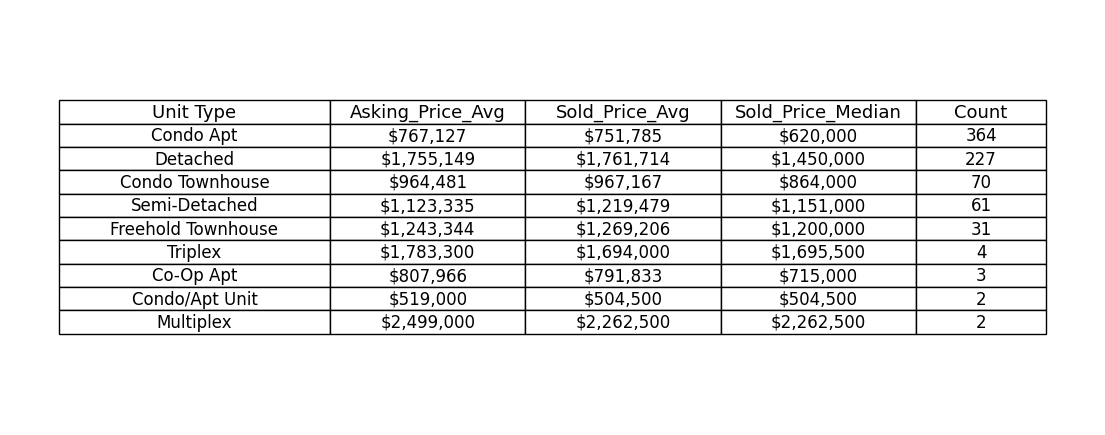

In [126]:
# Adjust the DataFrame to display
df_to_display = avg_prices  # Use your aggregated DataFrame

# Create the figure and axis with larger dimensions
fig, ax = plt.subplots(figsize=(14, len(df_to_display) * 0.6))  # Slightly wider figure
ax.axis('off')  # Hide the axis

# Create the table with improved alignment
table = ax.table(
    cellText=df_to_display.values,
    colLabels=df_to_display.columns,
    loc='center',
    cellLoc='center',        # Center-align cell content
    colLoc='center'          # Center-align column headers
)

# Adjust font size and scale for better fit
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.3, 1.4)  # Slightly increased scaling (width, height)

# Auto-adjust column widths based on content length
col_widths = [0.25, 0.18, 0.18, 0.18, 0.12]  # Adjusted column widths

# Apply column widths
for key, cell in table.get_celld().items():
    cell.set_text_props(ha='center', va='center')  # Center-align text
    if key[0] == 0:  # Header row
        cell.set_fontsize(13)  # Slightly larger font for headers
    if key[1] < len(col_widths):
        cell.set_width(col_widths[key[1]])  # Apply width based on column index

# Save the table as a high-resolution image
plt.savefig("average_prices_table_final.png", bbox_inches='tight', dpi=300)

# Optional: Display the image
plt.show()

##### Save tables as images (png)

In [127]:
scraper.save_table_as_image(
    avg_prices,
    "average_prices_table.png",
    col_widths=[0.25, 0.18, 0.18, 0.18, 0.12]  # Custom widths for 5 columns
)

scraper.save_table_as_image(
    avg_prices_with_count,
    "average_prices_with_bedrooms_table.png",
    col_widths=[0.20, 0.18, 0.10, 0.18, 0.18, 0.18]  # Adjusted widths for 6 columns
)

##### Print unique postal codes and postal code areas

In [128]:
filtered_sold_data_df["Postal Code Area"] = filtered_sold_data_df["Postal Code"].apply(lambda x: x[:3] if pd.notna(x) else "N/A")

print(filtered_sold_data_df['Postal Code'].unique())
print("\n--------")
print(filtered_sold_data_df['Postal Code Area'].unique())

['M4M0A6' 'M1N2J6' 'L5G1Y8' 'L4L0H8' 'M5H4C9' 'L4H1X1' 'M1M2M3' 'M4S0B9'
 'M4W3W6' 'L4W3C2' 'M4J4L4' 'L4K0M6' 'M1H1X6' 'L3S4P2' 'M6A1X5' 'M4W3Z4'
 'L4B4P6' 'M1B4H2' 'M2J0E2' 'L5A3G2' 'M1P4K6' 'M1R4M5' 'L4K0M7' 'M2N1J9'
 'M4K2X6' 'M9M0A5' 'M3A3C5' 'M4G1X7' 'M9W7J4' 'M4K1B5' 'M5P0A2' 'L5A3M2'
 'M3N1R9' 'M5V2K3' 'M6H3W3' 'L4W2S8' 'M6S3M5' 'L3R4G4' 'M5P2E7' 'M4W1K3'
 'M9A0A1' 'M1P3N8' 'M1S4V3' 'M9R1T4' 'M9W7J6' 'L5H1Y8' 'M8Y0C7' 'M9C4N8'
 'M6B3B4' 'M4V1Y1' 'M9C1G7' 'M4N3P9' 'M4M1M5' 'M1P4Z3' 'L4J7M2' 'M1V3S5'
 'L3R7E5' 'M1J1S8' 'M1J0A9' 'L5B0B9' 'L6A2Z5' 'L6B0V5' 'M3N2K9' 'M5V0L4'
 'M1T3S4' 'M1K5A7' 'M2K0B3' 'M5V1K5' 'M5S0A4' 'M9W4G9' 'M5V1B7' 'M5A0E7'
 'L6A0K1' 'M2N6G9' 'M1V3N4' 'M8V2L2' 'M6P2S5' 'L3T7W6' 'M1P4B4' 'L5G0B3'
 'L3R2T9' 'L4S0B1' 'L4Y2W4' 'M3C3P3' 'M3C1A1' 'M6M5A7' 'L4L1Y3' 'M6R1H5'
 'M1W3T8' 'M1R2C1' 'M5V0S6' 'M5V0J9' 'M2N0G5' 'M4S0B1' 'M6G4C2' 'L4L8B2'
 'L5A2S2' 'M2N7G3' 'M6B3L8' 'M9A4K5' 'M4M2P7' 'M1K3C7' 'M1S4Y8' 'L6A4X7'
 'M5B1L3' 'M4C4C6' 'M3K1A5' 'M8V1X5' 'L4J7K9' 'M3H0

##### Calculate average and median prices by postal code area

In [129]:
# ✅ Filter the original DataFrame BEFORE aggregation
filtered_data = filtered_sold_data_df[
    (~filtered_sold_data_df["Bedrooms"].isin(["1", "0"])) &  # ✅ Exclude Bedrooms = "1" or "0"
    (filtered_sold_data_df["Count"] > 1 if "Count" in filtered_sold_data_df.columns else True)  # Handle Count if it exists
]

# Group by Postal Code Area after filtering
postal_aggregates = (
    filtered_data.groupby("Postal Code Area")
    .agg(
        Asking_Price_Avg=("Asking Price", "mean"),
        Sold_Price_Avg=("Sold Price", "mean"),
        Sold_Price_Median=("Sold Price", "median"),
        Count=("Asking Price", "count")  # Counting the number of observations
    )
    .reset_index()
)

# ✅ Filter out postal codes where Count = 1 AFTER aggregation
postal_aggregates = postal_aggregates[postal_aggregates["Count"] > 1]

# ✅ Sort by Sold_Price_Median in descending order BEFORE formatting
postal_aggregates = postal_aggregates.sort_values(by="Sold_Price_Median", ascending=False)

# Format the average prices, median, and counts for better readability
postal_aggregates["Asking_Price_Avg"] = postal_aggregates["Asking_Price_Avg"].apply(lambda x: f"${x:,.0f}")
postal_aggregates["Sold_Price_Avg"] = postal_aggregates["Sold_Price_Avg"].apply(lambda x: f"${x:,.0f}")
postal_aggregates["Sold_Price_Median"] = postal_aggregates["Sold_Price_Median"].apply(lambda x: f"${x:,.0f}")
postal_aggregates["Count"] = postal_aggregates["Count"].apply(lambda x: f"{x:,}")

# Display the sorted DataFrame
print(postal_aggregates.to_string(index=False))

Postal Code Area Asking_Price_Avg Sold_Price_Avg Sold_Price_Median Count
      M5S           $3,785,500      $3,553,250       $3,054,000       4 
      M2L           $3,913,250      $3,666,750       $2,868,500       4 
      L5H           $2,894,000      $2,697,500       $2,697,500       2 
      L5G           $2,727,450      $2,555,000       $2,650,000       4 
      M4V           $2,560,000      $2,666,286       $2,600,000       7 
      L4S           $1,943,844      $2,034,000       $2,034,000       2 
      M6C           $2,108,000      $2,106,509       $2,020,000       4 
      M6R           $1,824,666      $1,831,000       $2,001,000       3 
      M4N           $1,866,500      $1,926,000       $1,926,000       2 
      M2R           $1,949,000      $1,850,000       $1,850,000       2 
      M4K           $1,428,000      $1,745,585       $1,776,500       6 
      L4C           $2,032,738      $1,988,875       $1,726,500       8 
      M5R           $2,584,211      $2,584,667     

In [130]:
# Group by Postal Code Area and Unit Type
postal_unit_aggregates = (
    filtered_sold_data_df.groupby(["Postal Code Area", "Unit Type"])
    .agg(
        Asking_Price_Avg=("Asking Price", "mean"),
        Sold_Price_Avg=("Sold Price", "mean"),
        Sold_Price_Median=("Sold Price", "median"),
        Count=("Asking Price", "count")  # Counting the number of observations
    )
    .reset_index()
)

# Format the average prices, median, and counts for better readability
postal_unit_aggregates["Asking_Price_Avg"] = postal_unit_aggregates["Asking_Price_Avg"].apply(lambda x: f"${x:,.0f}")
postal_unit_aggregates["Sold_Price_Avg"] = postal_unit_aggregates["Sold_Price_Avg"].apply(lambda x: f"${x:,.0f}")
postal_unit_aggregates["Sold_Price_Median"] = postal_unit_aggregates["Sold_Price_Median"].apply(lambda x: f"${x:,.0f}")
postal_unit_aggregates["Count"] = postal_unit_aggregates["Count"].apply(lambda x: f"{x:,}")

# Display the aggregated DataFrame
print(postal_unit_aggregates.to_string(index=False))

Postal Code Area     Unit Type      Asking_Price_Avg Sold_Price_Avg Sold_Price_Median Count
      L3P                 Condo Apt      $799,800        $765,000         $765,000       1 
      L3P           Condo Townhouse      $899,000        $890,000         $890,000       1 
      L3P                  Detached    $2,788,500      $2,525,200       $2,525,200       2 
      L3R                 Condo Apt    $1,291,250      $1,185,125         $982,750       4 
      L3R           Condo Townhouse      $849,450        $936,500         $936,500       2 
      L3R                  Detached    $2,533,327      $2,385,629       $2,728,888       3 
      L3S                  Detached    $1,154,200      $1,171,000       $1,217,500       4 
      L3S             Semi-Detached    $1,173,500      $1,157,000       $1,157,000       2 
      L3T                 Condo Apt      $664,580        $645,500         $554,500       5 
      L3T           Condo Townhouse      $814,333        $784,833         $768,0

##### Print data for specific Postal Code Area

In [131]:
# ✅ Set display options for better formatting
pd.set_option('display.max_columns', None)        # Show all columns without truncation
pd.set_option('display.width', 200)               # Increase display width to prevent line breaks
pd.set_option('display.max_colwidth', None)       # Prevent truncation of long text (like addresses)
pd.set_option('display.colheader_justify', 'center')  # Center-align column headers

# ✅ Check data for a specific postal code area
select_cols = ["Postal Code Area", "Address", "Bedrooms", "Asking Price", "Sold Price"]
check_area = "M1H"

# ✅ Filter the data
filtered_data = filtered_sold_data_df[filtered_sold_data_df["Postal Code Area"] == check_area][select_cols].copy()
filtered_data = filtered_data[filtered_data['Bedrooms'] != '1']

# ✅ Format dollar values with $ and commas
filtered_data["Asking Price"] = filtered_data["Asking Price"].apply(lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A")
filtered_data["Sold Price"] = filtered_data["Sold Price"].apply(lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A")

# ✅ Display the data without showing the index
print(filtered_data.to_string(index=False))

Postal Code Area                 Address                 Bedrooms Asking Price Sold Price
      M1H        82 Sedgemount Dr , Scarborough - Woburn   3+4     $1,129,000  $1,100,000
      M1H         99 Rochman Blvd , Scarborough - Woburn     3       $749,900    $820,000
      M1H        175 Lynnbrook Dr , Scarborough - Woburn   3+3       $999,999  $1,260,000


##### Save scraped data as csv

In [132]:
print(filtered_sold_data_df.shape)
print(filtered_sold_data_df.columns)
print("\n" + "=" * 50)  # Separator line
print(filtered_sold_data_df.head(20))

filtered_sold_data_df.to_csv('filtered_sold_data.csv', index=False)

(764, 10)
Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code', 'Listing URL', 'Bedroom Category', 'Postal Code Area'], dtype='object')

    Asking Price   Sold Price                           Address                              Unit Type     Bedrooms Bathrooms Postal Code  \
0    $998,000.00   $975,000.00           623 - 88 Colgate Ave , Toronto - South Riverdale        Condo Apt      2        2       M4M0A6     
1  $1,259,000.00 $1,349,000.00   84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside         Detached      4        5       M1N2J6     
2  $3,599,900.00 $3,250,000.00                    501 Avonwood Dr , Mississauga - Mineola         Detached      4        4       L5G1Y8     
3    $825,000.00   $780,000.00        314 - 199 Pine Grove Rd , Vaughan - East Woodbridge  Condo Townhouse      2        2       L4L0H8     
4    $559,000.00   $529,000.00  517 - 168 Simcoe St , Toronto - Waterfront Communities C1        Condo Apt     

##### Loop through listing URLs to get more info about each listing

In [51]:
# test function save_listing_url_html
test_url = prices_df_temp['Listing URL'][0]
unit_type_test = prices_df_temp['Unit Type'][0]
print(f"\nGetting data for unit {unit_type_test}, URL: {test_url}")


Getting data for unit Condo Apt, URL: https://housesigma.com/on/toronto-real-estate/623-88-colgate-ave/home/DnM697koZNd7bmwe/


##### Test function save_listing_url_html

In [52]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

# options = webdriver.ChromeOptions()
# options.add_argument("--disable-blink-features=AutomationControlled")
# options.add_experimental_option("excludeSwitches", ["enable-automation"])
# options.add_experimental_option("useAutomationExtension", False)

# driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# # ✅ Open HouseSigma for manual login
# driver.get("https://housesigma.com")
# input("🔑 Press Enter after logging in manually...")  # ⬅️ Login manually, then press Enter

# output_filename = "listing_page.html"

# # ✅ Save the full HTML content
# scraper.save_listing_url_html(driver, test_url, unit_type_test)

# # ✅ Close the browser after saving
# driver.quit()

##### Loop through listing urls
###### Filter for specific units / bedrooms (otherwise takes a long time to run through all urls)

In [133]:
print(filtered_sold_data_df['Bedroom Category'].unique())
print("\n" + "=" * 50)  # Separator line

bedroom_counts = filtered_sold_data_df['Bedroom Category'].value_counts()

# Print the counts by Bedroom Category
print(bedroom_counts)

['2' '3+' '1' '1+1' '2+1' '2+2' '0' '0+1']

Bedroom Category
3+     371
2      161
1+1     90
2+1     74
1       58
2+2      5
0        4
0+1      1
Name: count, dtype: int64


In [61]:
# Define the categories you want to filter
desired_categories = ['3+', '2+1', '2+2']

# Filter the DataFrame based on the desired categories
subset_df = filtered_sold_data_df[filtered_sold_data_df['Bedroom Category'].isin(desired_categories)].copy().reset_index(drop=True)

print(subset_df.shape)

# Save the subset DataFrame to a CSV file
subset_df.to_csv('subset_bedroom_categories.csv', index=False)

# Print the first few rows of the subset DataFrame to verify
print(subset_df.head())

(473, 10)
   Asking Price  Sold Price                          Address                          Unit Type Bedrooms Bathrooms Postal Code  \
0    1259000.0    1349000.0  84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside  Detached     4         5       M1N2J6     
1    3599900.0    3250000.0                   501 Avonwood Dr , Mississauga - Mineola  Detached     4         4       L5G1Y8     
2    1399999.0    1430000.0                 22 Sgotto Blvd , Vaughan - Sonoma Heights  Detached     3         4       L4H1X1     
3    1295000.0    1249000.0                63 Thatcher Ave , Scarborough - Cliffcrest  Detached     3         3       M1M2M3     
4    1079000.0    1070000.0                4254 Poltava Cres , Mississauga - Rathwood  Detached     4         2       L4W3C2     

                                          Listing URL                                          Bedroom Category Postal Code Area  
0  https://housesigma.com/on/scarborough-real-estate/84a-aylesworth-ave/home/L

In [62]:
print("🔄 Reinitializing WebDriver...")

options = webdriver.ChromeOptions()
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ✅ Open HouseSigma for manual login
driver.get("https://housesigma.com")
input("🔑 Press Enter after logging in manually...")  # ⬅️ Login manually, then press Enter

extracted_data = scraper.process_with_progress(subset_df, driver, progress_interval=100)

# ✅ Convert the extracted dictionary output into a DataFrame
extracted_df = extracted_data.apply(pd.Series)

# ✅ Close the browser after processing all listings
driver.quit()
print(extracted_df.shape)
print("\n✅ All listings processed. Browser closed.")

🔄 Reinitializing WebDriver...
🚀 Processing row 1/473
🚀 Processing row 101/473
🚀 Processing row 201/473
🚀 Processing row 301/473
🚀 Processing row 401/473
🚀 Processing row 473/473
(473, 3)

✅ All listings processed. Browser closed.


In [63]:
print(extracted_df.shape)

# Save the subset DataFrame to a CSV file
extracted_df.to_csv('extracted_df.csv', index=False)

(473, 3)


###### Check results

In [64]:
print(extracted_df.shape)
print("\n" + "=" * 50)  # Separator line
print(extracted_df.head())

# ✅ Convert "Sold Days Ago" into "Sale Date"
extracted_df["Sold Days Ago"] = pd.to_numeric(extracted_df["Sold Days Ago"], errors="coerce")
extracted_df["Sale Date"] = (pd.to_datetime("today") - pd.to_timedelta(extracted_df["Sold Days Ago"], unit="D")).dt.strftime("%Y-%m-%d")
extracted_df["Sale Date"] = extracted_df["Sale Date"].fillna("N/A")

print("\n" + "=" * 50)  # Separator line
print(extracted_df.shape)
print(extracted_df.head())

subset_df = pd.concat([subset_df, extracted_df], axis=1)
print("\n" + "=" * 50)  # Separator line
print(subset_df.shape)
print(subset_df.head())

(473, 3)

  Sold Days Ago Maintenance Fees  \
0       N/A            N/A         
1       N/A            N/A         
2         1            N/A         
3         1            N/A         
4         1            N/A         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Unit Description                                                                                                      

In [65]:
# Count the number of units with NA in the 'Sold Days Ago' column
na_sold_days_ago_count = subset_df['Sold Days Ago'].isna().sum()

# Print the count
print(f"Number of units with NA for 'Sold Days Ago': {na_sold_days_ago_count}")

Number of units with NA for 'Sold Days Ago': 6


###### Update sold days ago and sold date

In [66]:
# Create 'Sold Days Ago Adjusted' column
subset_df['Sold Days Ago Adjusted'] = subset_df['Sold Days Ago'].fillna(0)

# Update 'Sale Date' for rows where 'Sold Days Ago' was NA
subset_df['Sale Date Adjusted'] = subset_df['Sale Date']
subset_df.loc[subset_df['Sold Days Ago'].isna(), 'Sale Date Adjusted'] = pd.to_datetime('today').strftime('%Y-%m-%d')

# Print the first few rows to verify
print(subset_df.head())

   Asking Price  Sold Price                          Address                          Unit Type Bedrooms Bathrooms Postal Code  \
0    1259000.0    1349000.0  84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside  Detached     4         5       M1N2J6     
1    3599900.0    3250000.0                   501 Avonwood Dr , Mississauga - Mineola  Detached     4         4       L5G1Y8     
2    1399999.0    1430000.0                 22 Sgotto Blvd , Vaughan - Sonoma Heights  Detached     3         4       L4H1X1     
3    1295000.0    1249000.0                63 Thatcher Ave , Scarborough - Cliffcrest  Detached     3         3       M1M2M3     
4    1079000.0    1070000.0                4254 Poltava Cres , Mississauga - Rathwood  Detached     4         2       L4W3C2     

                                          Listing URL                                          Bedroom Category Postal Code Area  Sold Days Ago Maintenance Fees  \
0  https://housesigma.com/on/scarborough-real-estate/84

In [67]:
# Save the subset DataFrame to a CSV file
subset_df.to_csv('subset_df_filled.csv', index=False)

##### Determine approximate monthly costs

In [134]:
# Load DataFrame from CSV
subset_df = pd.read_csv("subset_df_filled.csv")

# Print columns and initial shape
print(subset_df.columns)
print("\n" + "=" * 50)  # Separator line
print(f"Rows before removing duplicates: {subset_df.shape[0]}")

# Remove duplicates
subset_df = subset_df.drop_duplicates()

# Print shape after duplicates removal
print(f"Rows after removing duplicates: {subset_df.shape[0]}")
print("\n" + "=" * 50)

# Print first 20 Maintenance Fees
print(subset_df['Maintenance Fees'][:20])

Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code', 'Listing URL', 'Bedroom Category', 'Postal Code Area', 'Sold Days Ago', 'Maintenance Fees',
       'Unit Description', 'Sale Date', 'Sold Days Ago Adjusted', 'Sale Date Adjusted'],
      dtype='object')

Rows before removing duplicates: 473
Rows after removing duplicates: 450

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8     $739/month
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
16           NaN
17           NaN
18    $467/month
19           NaN
20           NaN
Name: Maintenance Fees, dtype: object


##### Convert maintenance fees to numeric
Calculate monthly mortgage cost

In [135]:
# Convert Maintenance Fees:
subset_df["Maintenance Fees"] = (
    subset_df["Maintenance Fees"]
    .astype(str)  # Ensure all values are treated as strings
    .str.replace(r"[^\d.]", "", regex=True)  # Remove non-numeric characters ($, /month, etc.)
    .replace("", "0")  # Replace empty values (from NaN conversion) with "0"
    .astype(float)  # Convert to float
)

subset_df["Monthly Mortgage"] = subset_df["Sold Price"].apply(
    lambda x: scraper.calculate_mortgage(x, interest_rate=0.04, loan_term_years=25)
)

print(subset_df.head())

   Asking Price   Sold Price                           Address                          Unit Type Bedrooms  Bathrooms Postal Code  \
0 $1,259,000.00 $1,349,000.00  84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside  Detached     4         5        M1N2J6     
1 $3,599,900.00 $3,250,000.00                   501 Avonwood Dr , Mississauga - Mineola  Detached     4         4        L5G1Y8     
2 $1,399,999.00 $1,430,000.00                 22 Sgotto Blvd , Vaughan - Sonoma Heights  Detached     3         4        L4H1X1     
3 $1,295,000.00 $1,249,000.00                63 Thatcher Ave , Scarborough - Cliffcrest  Detached     3         3        M1M2M3     
4 $1,079,000.00 $1,070,000.00                4254 Poltava Cres , Mississauga - Rathwood  Detached     4         2        L4W3C2     

                                          Listing URL                                          Bedroom Category Postal Code Area  Sold Days Ago  Maintenance Fees  \
0  https://housesigma.com/on/scarbor

##### Check Maintenance Fees values

In [136]:
# Find rows with Maintenance Fees = 0 and Unit Type containing 'condo'
condo_zero_fees = subset_df[(subset_df['Maintenance Fees'] == 0) & 
                            (subset_df['Unit Type'].str.contains('condo', case=False, na=False))]

# Print number of such rows and the rows themselves
print(f"Number of condos with zero maintenance fees: {condo_zero_fees.shape[0]}")
print("\n" + "=" * 50)
print(condo_zero_fees)

Number of condos with zero maintenance fees: 1

     Asking Price  Sold Price                    Address                     Unit Type  Bedrooms  Bathrooms Postal Code  \
102  $528,000.00  $520,000.00  508 - 400 Mclevin Ave , Scarborough - Malvern  Condo Apt    2+1        2        M1B5J4     

                                             Listing URL                                          Bedroom Category Postal Code Area  Sold Days Ago  Maintenance Fees  \
102  https://housesigma.com/on/scarborough-real-estate/508-400-mclevin-ave/home/02Zpj39BQZnYDrK8/        2+1              M1B            NaN             $0.00         

                                                                                                                                                                                                                                                      Unit Description                                                                                                          

##### Update missing maintenance fees

In [ ]:
print("🔄 Reinitializing WebDriver...")

options = webdriver.ChromeOptions()
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ✅ Open HouseSigma for manual login
driver.get("https://housesigma.com")
input("🔑 Press Enter after logging in manually...")  # ⬅️ Login manually, then press Enter

for idx, row in condo_zero_fees.iterrows():
    old_fee = subset_df.loc[idx, 'Maintenance Fees']
    result = scraper.save_listing_url_html(driver, row['Listing URL'], row['Unit Type'])
    new_fee_str = result.get("Maintenance Fees", "0")  # e.g. "$894/month"

    fee_numeric_str = re.sub(r'[^\d\.]', '', new_fee_str)  # "894"
    new_fee = float(fee_numeric_str) if fee_numeric_str else 0.0

    # 🚨 This line is critical!
    subset_df.loc[idx, 'Maintenance Fees'] = new_fee  # <--- ASSIGN!

    updated_fee = subset_df.loc[idx, 'Maintenance Fees']
    if updated_fee == new_fee and old_fee != new_fee:
        print(f"Row {idx}: Maintenance Fees updated from {old_fee} to {updated_fee}")
    else:
        print(f"Row {idx}: Maintenance Fees NOT updated (old={old_fee}, new={updated_fee})")

driver.quit()

🔄 Reinitializing WebDriver...
Row 102: Maintenance Fees NOT updated (old=$894/month, new=$894/month)


In [147]:
print(result)

{'Sold Days Ago': '14', 'Maintenance Fees': '$894/month', 'Unit Description': "Step into a world of comfort and style with this exceptional corner unit, ideally situated at McLevin Ave &Neilson Rd! Spanning an expansive 1,200 sq. ft., this home offers a bright and airy eat-in kitchen, a huge open balcony perfect for relaxing or entertaining, and 2 spacious bedrooms. Plus, a flexible den provides the option to easily create a third bedroom or home office to suit your lifestyle. Enjoy resort-like living with access to top-tier recreational facilities and 24-hour security for your peace of mind. With TTC and all essential amenities just steps away, convenience is at your doorstep. This is more than just a home it's a lifestyle! **EXTRAS** Parking B2 #61, locker # 141"}


In [148]:
# Calculate average maintenance fees and counts by Unit Type
maintenance_summary = subset_df.groupby("Unit Type")["Maintenance Fees"].agg(
    Avg_Maintenance_Fee="mean",  # Compute average
    Count="count"  # Count number of entries per unit type
).round(2)  # Round average fees to 2 decimal places

# Print results
print(maintenance_summary)

TypeError: agg function failed [how->mean,dtype->object]

###### Calculate total monthly cost

In [94]:
# Calculate Total Monthly Cost (Mortgage + Maintenance Fees)
subset_df["Total Monthly Cost"] = subset_df["Monthly Mortgage"] + subset_df["Maintenance Fees"]

print(subset_df.head())

   Asking Price  Sold Price                          Address                          Unit Type Bedrooms  Bathrooms Postal Code  \
0    1259000.0    1349000.0  84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside  Detached     4         5        M1N2J6     
1    3599900.0    3250000.0                   501 Avonwood Dr , Mississauga - Mineola  Detached     4         4        L5G1Y8     
2    1399999.0    1430000.0                 22 Sgotto Blvd , Vaughan - Sonoma Heights  Detached     3         4        L4H1X1     
3    1295000.0    1249000.0                63 Thatcher Ave , Scarborough - Cliffcrest  Detached     3         3        M1M2M3     
4    1079000.0    1070000.0                4254 Poltava Cres , Mississauga - Rathwood  Detached     4         2        L4W3C2     

                                          Listing URL                                          Bedroom Category Postal Code Area  Sold Days Ago  Maintenance Fees  \
0  https://housesigma.com/on/scarborough-real-es

##### Total monthly cost by Postal Code Area

In [106]:
# Group by Postal Code Area and calculate average, median, and count of monthly costs
monthly_cost_summary = subset_df.groupby("Postal Code Area")["Total Monthly Cost"].agg(
    Avg_Monthly_Cost="mean",  # Compute average
    Median_Monthly_Cost="median",  # Compute median
    Units_Sold_Count="count"  # Count number of listings per postal code
).round(2)  # Round values to 2 decimal places

# Sort in descending order by Average Monthly Cost
monthly_cost_summary = monthly_cost_summary.sort_values(by="Median_Monthly_Cost", ascending=True)

# Ensure Pandas prints more rows & wider columns
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.float_format", lambda x: f"${x:,.2f}")  # Format numbers as currency

# Ensure "Count" column does not get dollar formatting
monthly_cost_summary["Units_Sold_Count"] = monthly_cost_summary["Units_Sold_Count"].astype(int)

# Display the DataFrame in a readable format
print(monthly_cost_summary)

                  Avg_Monthly_Cost  Median_Monthly_Cost  Units_Sold_Count
Postal Code Area                                                         
M3C                   $3,000.24          $2,974.57               4       
M1G                   $3,371.51          $3,371.51               2       
M1B                   $3,389.82          $3,452.07               7       
M3L                   $3,790.57          $3,494.28               6       
M9V                   $3,571.53          $3,583.81               4       
M2M                   $4,075.11          $3,584.75               5       
M9L                   $3,631.52          $3,631.52               1       
M9W                   $3,716.33          $3,631.52               7       
L5A                   $3,764.35          $3,632.57               9       
M9M                   $3,722.38          $3,722.38               2       
M5B                   $3,728.55          $3,728.55               2       
M3J                   $4,298.90       

##### Print examples of listings

In [111]:
check_postal_code = 'M3L'
select_cols = ['Postal Code Area', 'Address', 'Unit Type', 'Bedrooms', 'Sold Price', 'Maintenance Fees', 'Monthly Mortgage', 'Total Monthly Cost' ,'Listing URL']

# Filter DataFrame
filtered_df = subset_df[subset_df['Postal Code Area'] == check_postal_code][select_cols].copy().reset_index(drop=True)

# Convert currency columns to formatted strings
currency_cols = ['Sold Price', 'Maintenance Fees', 'Monthly Mortgage', 'Total Monthly Cost']
for col in currency_cols:
    filtered_df[col] = filtered_df[col].apply(lambda x: f"${x:,.2f}")  # Format as currency

# Print DataFrame as a table without index
print(filtered_df.to_string(index=False))

Postal Code Area                           Address                                Unit Type      Bedrooms   Sold Price  Maintenance Fees Monthly Mortgage Total Monthly Cost                                           Listing URL                                           
      M3L                112 Arleta Ave , North York - Glenfield-Jane Heights           Detached   3+1    $1,225,000.00      $0.00          $5,172.80         $5,172.80                https://housesigma.com/on/north-york-real-estate/112-arleta-ave/home/GMnKYqpLp6R3w1Qr/
      M3L                26 Thurrock Rd , North York - Glenfield-Jane Heights      Semi-Detached   3+3      $850,000.00      $0.00          $3,589.29         $3,589.29                https://housesigma.com/on/north-york-real-estate/26-thurrock-rd/home/damgL7AZoPL3Z1MW/
      M3L        77 ODOARDO DI SANTO Circ , North York - Downsview-Roding-CFB Freehold Townhouse   3+1      $783,000.00      $0.00          $3,306.37         $3,306.37      https://housesigm